# Gradient Boosting (XGBoost)

In [115]:
# Libraries
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
import joblib

## 1. Loading the Data

In [116]:
df = pd.read_csv('..\\data\\processed\\final_df.csv', parse_dates=True, index_col=0)
df.index = pd.to_datetime(df.index)

df.columns

Index(['Hour', 'Little Collins St-Swanston St (East)',
       'Faraday St-Lygon St (West)', 'Melbourne Central',
       'Chinatown-Lt Bourke St (South)', 'Lonsdale St (South)',
       'Lygon St (West)', 'IsPublicHoliday', 'temp', 'humidity', 'rain_1h',
       'clouds_all', 'Weekday_2', 'Weekday_3', 'Weekday_4', 'Weekday_5',
       'Weekday_6', 'Weekday_7', 'Month_2', 'Month_3', 'Month_4', 'Month_5',
       'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11',
       'Month_12', 'Season_Spring', 'Season_Summer', 'Season_Winter'],
      dtype='object')

In [117]:
# Feature Scaling
scaler = MinMaxScaler()
weather_features = ['temp', 'humidity', 'rain_1h', 'clouds_all']
df[weather_features] = scaler.fit_transform(df[weather_features])

# print(data[weather_features].describe())

## 2. Feature Selection

In [118]:
# Separate features and target
target_columns = [
    'Little Collins St-Swanston St (East)', 
    'Faraday St-Lygon St (West)', 
    'Melbourne Central',
    'Chinatown-Lt Bourke St (South)',
    'Lonsdale St (South)'
]

# Add lagged features (they capture pedestrian flow from the previous hour)
for sensor in target_columns:
    df[f'{sensor}_Lag_1'] = df[sensor].shift(1)

# Add rolling averages (capture the short term trends over the last 7 hours)
for sensor in target_columns:
    df[f'Rolling_7_{sensor}'] = df[sensor].rolling(window=7, min_periods=1).mean()


In [119]:
#Editing the feature list
# Adding hour as a feature
df['Hour'] = df.index.hour

# interaction feature
df['Rain_Holiday'] = df['rain_1h'] * df['IsPublicHoliday']

features = [
    'IsPublicHoliday', 'Hour',
    'Weekday_2', 'Weekday_3', 'Weekday_4', 'Weekday_5', 'Weekday_6', 'Weekday_7',
    'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
    'Season_Spring', 'Season_Summer', 'Season_Winter',
    'temp', 'humidity', 'rain_1h', 'clouds_all'
] + \
[f'Rolling_7_{sensor}' for sensor in target_columns] + \
[f'{sensor}_Lag_1' for sensor in target_columns]

In [120]:
# df = df.dropna()


In [121]:
# Split into train and test sets
train = df[df.index < "2024-05-01"]
test = df[df.index >= "2024-05-01"]

X_train = train[features]
X_test = test[features]
y_train = train[target_columns]
y_test = test[target_columns]


print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: (18264, 36), y_train: (18264, 5)
X_test: (4416, 36), y_test: (4416, 5)


In [122]:
# Aggregated Forecast
# df['Count'] = (
#     df['Little Collins St-Swanston St (East)'] +
#     df['Faraday St-Lygon St (West)'] +
#     df['Melbourne Central'] +
#     df['Chinatown-Lt Bourke St (South)'] +
#     df['Lonsdale St (South)']
# )

# X_train = train[features]
# y_train = train['Count']

# X_test = test[features]
# y_test = test['Count']

## 3. Model

In [123]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [124]:
models = {}

for sensor in target_columns:
    print(f"Training model for {sensor}...")
    
    model = xgb.XGBRegressor(
        objective='reg:squarederror', 
        n_estimators=100,             
        learning_rate=0.1,
        max_depth=6,
        random_state=42
    )
    
    model.fit(X_train, y_train[sensor])
    models[sensor] = model
    print(f"Completed training for {sensor}")

Training model for Little Collins St-Swanston St (East)...
Completed training for Little Collins St-Swanston St (East)
Training model for Faraday St-Lygon St (West)...
Completed training for Faraday St-Lygon St (West)
Training model for Melbourne Central...
Completed training for Melbourne Central
Training model for Chinatown-Lt Bourke St (South)...
Completed training for Chinatown-Lt Bourke St (South)
Training model for Lonsdale St (South)...
Completed training for Lonsdale St (South)


In [125]:
# Model Evaluation
for sensor in target_columns:
    predictions = models[sensor].predict(X_test)
    
    # Metrics
    rmse = root_mean_squared_error(y_test[sensor], predictions)
    mape = mean_absolute_percentage_error(y_test[sensor], predictions)
    r2 = r2_score(y_test[sensor], predictions)
    
    # Print metrics
    print(f"Evaluation for {sensor}:")
    print(f"  RMSE: {rmse}")
    print(f"  MAPE: {mape}")
    print(f"  R²: {r2}")


Evaluation for Little Collins St-Swanston St (East):
  RMSE: 120.98549984495062
  MAPE: 1253553875873614.2
  R²: 0.9637725450082357
Evaluation for Faraday St-Lygon St (West):
  RMSE: 31.38757961338236
  MAPE: 555788421759926.0
  R²: 0.9713284044056746
Evaluation for Melbourne Central:
  RMSE: 139.6879323698401
  MAPE: 357958540522718.8
  R²: 0.9781942425508837
Evaluation for Chinatown-Lt Bourke St (South):
  RMSE: 71.83795777916202
  MAPE: 6890805836268232.0
  R²: 0.944830100724928
Evaluation for Lonsdale St (South):
  RMSE: 50.161246891908405
  MAPE: 699362814307936.6
  R²: 0.972987872223629


## 4. Hyperparamter Tuning

In [126]:
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300, 400]
}

In [127]:
random_search = RandomizedSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    param_distributions=param_grid,
    n_iter=30,                         # Randomly sample 30 combinations
    scoring='neg_mean_squared_error',  # Minimize RMSE
    verbose=2,
    n_jobs=-1
)

In [128]:
tuned_models = {}

for sensor in target_columns:
    print(f"Optimizing hyperparameters for {sensor}...")
    random_search.fit(X_train, y_train[sensor])
    
    # Save the best model
    tuned_models[sensor] = random_search.best_estimator_
    print(f"Best parameters for {sensor}: {random_search.best_params_}")

Optimizing hyperparameters for Little Collins St-Swanston St (East)...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters for Little Collins St-Swanston St (East): {'subsample': 1.0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.8}
Optimizing hyperparameters for Faraday St-Lygon St (West)...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters for Faraday St-Lygon St (West): {'subsample': 1.0, 'n_estimators': 400, 'min_child_weight': 5, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.8}
Optimizing hyperparameters for Melbourne Central...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters for Melbourne Central: {'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.8}
Optimizing hyperparameters for Chinatown-Lt Bourke St (South)...

In [129]:
# Save the best model
import joblib

# Save trained models
for sensor, model in tuned_models.items():
    joblib.dump(model, f"{sensor}_xgboost_model.pkl")

print("Trained models saved as pickle files.")


Trained models saved as pickle files.


## 5. Cross-Validation

We use TimeSeriesSplit for cross-validation with RandomSearchVC

In [130]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5) 
random_search.cv = tscv     

In [131]:
for sensor in target_columns:
    print(f"Cross-validating model for {sensor}...")
    random_search.cv = tscv
    random_search.fit(X_train, y_train[sensor])
    
    # Save the cross-validated model
    tuned_models[sensor] = random_search.best_estimator_
    print(f"Cross-validated best parameters for {sensor}: {random_search.best_params_}")


Cross-validating model for Little Collins St-Swanston St (East)...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Cross-validated best parameters for Little Collins St-Swanston St (East): {'subsample': 0.6, 'n_estimators': 400, 'min_child_weight': 5, 'max_depth': 10, 'learning_rate': 0.01, 'gamma': 0.3, 'colsample_bytree': 1.0}
Cross-validating model for Faraday St-Lygon St (West)...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Cross-validated best parameters for Faraday St-Lygon St (West): {'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 1.0}
Cross-validating model for Melbourne Central...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Cross-validated best parameters for Melbourne Central: {'subsample': 0.6, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 1.0}
Cross-validating model for 

## 6. Evaluation of tuned models

In [132]:
for sensor in target_columns:
    predictions = tuned_models[sensor].predict(X_test)
    rmse = root_mean_squared_error(y_test[sensor], predictions)
    mape = mean_absolute_percentage_error(y_test[sensor], predictions)
    r2 = r2_score(y_test[sensor], predictions)

    print(f"Performance for {sensor}:")
    print(f"  RMSE: {rmse}")
    print(f"  MAPE: {mape}")
    print(f"  R²: {r2}")

Performance for Little Collins St-Swanston St (East):
  RMSE: 122.81208844223592
  MAPE: 1154008749224470.5
  R²: 0.9626703934304198
Performance for Faraday St-Lygon St (West):
  RMSE: 30.6425659101738
  MAPE: 544015527121549.2
  R²: 0.9726733455161256
Performance for Melbourne Central:
  RMSE: 142.5907781524795
  MAPE: 421726978146779.06
  R²: 0.9772785377571295
Performance for Chinatown-Lt Bourke St (South):
  RMSE: 72.99837531996243
  MAPE: 7769725222408608.0
  R²: 0.9430333573931845
Performance for Lonsdale St (South):
  RMSE: 50.362046386661994
  MAPE: 699642827501864.9
  R²: 0.9727711759354283


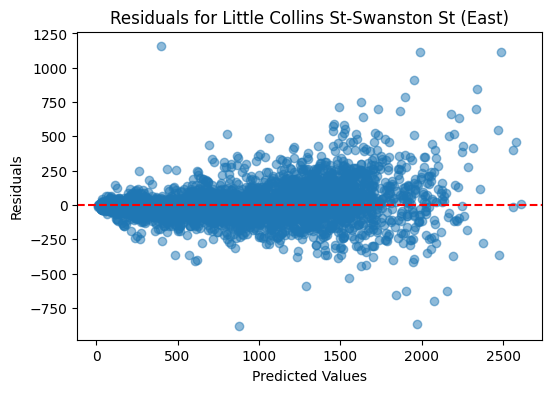

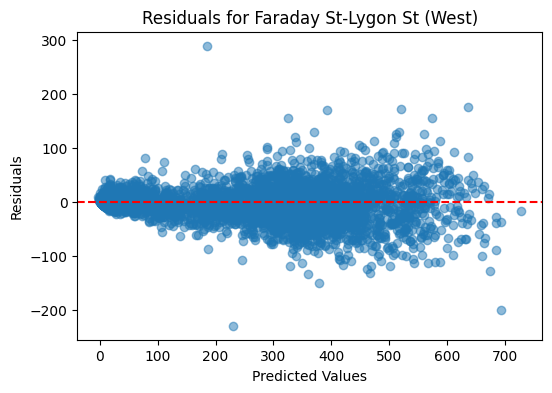

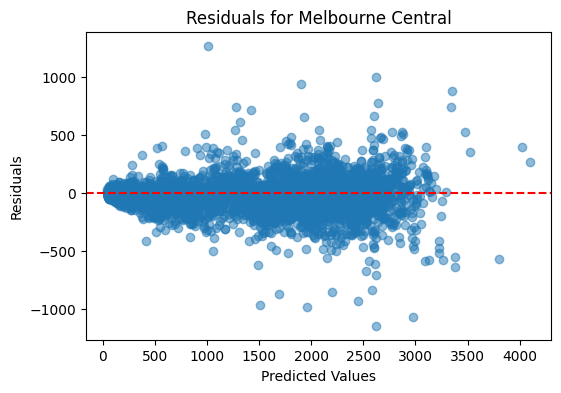

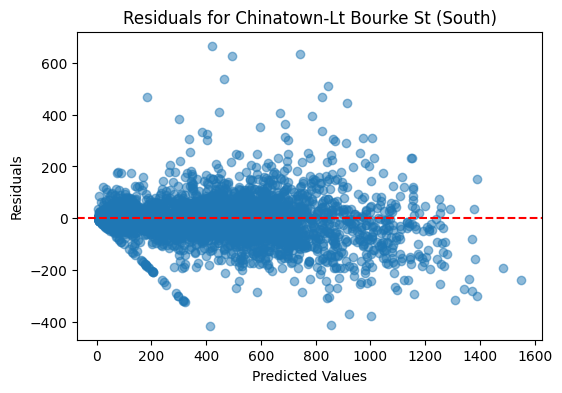

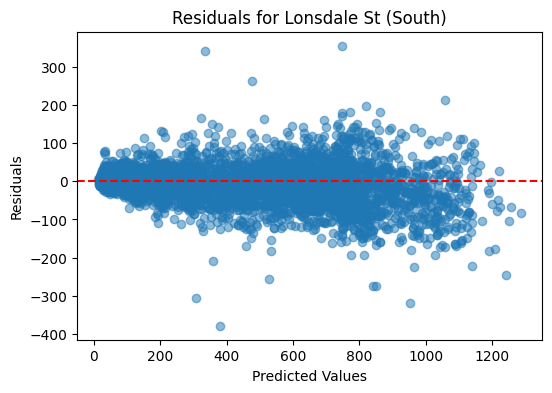

In [133]:
# Analysis of the Residuals
for sensor in target_columns:
    predictions = tuned_models[sensor].predict(X_test)
    residuals = y_test[sensor] - predictions

    # Scatter plot of residuals
    plt.figure(figsize=(6, 4))
    plt.scatter(predictions, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f"Residuals for {sensor}")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.show()
